In [1]:
import pandas as pd
import torch
import torch.optim as optim
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# Hinged Square Loss
class SquaredHingeLoss(nn.Module):
    def __init__(self, margin=1):
        super(SquaredHingeLoss, self).__init__()
        self.margin = margin

    def forward(self, predicted, y):
        low, high = y[:, 0:1], y[:, 1:2]
        loss_low = torch.relu(low - predicted + self.margin)
        loss_high = torch.relu(predicted - high + self.margin)
        loss = loss_low + loss_high
        return torch.mean(torch.square(loss))

In [3]:
class SplineNN(nn.Module):
    def __init__(self, input_size, knot):
        super(SplineNN, self).__init__()
        self.input_size = input_size
        self.knot = knot
        
        # Initialize parameters for piecewise function
        self.m1 = nn.Parameter(torch.ones(input_size))  # Slope for x <= x0
        self.m2 = nn.Parameter(torch.ones(input_size))  # Slope for x > x0
        self.b1 = nn.Parameter(torch.tensor(0.0))  # Intercept for x <= x0

    def forward(self, x):
        x = x.view(-1, self.input_size)
        
        # Compute outputs for both regions
        y1 = self.m1 * x + self.b1
        y2 = self.m2 * x + (self.m1 * self.knot + self.b1 - self.m2 * self.knot)
        
        # Sharp transition: use conditional logic to select y1 or y2
        return torch.where(x <= self.knot, y1, y2)

In [4]:
class ModelTrainer:
    def __init__(self, dataset, chosen_feature, test_fold):
        self.dataset = dataset
        self.chosen_feature = chosen_feature
        self.test_fold = test_fold
        self.SplineNN = SplineNN
        self.load_data()
        self.prepare_data()
        self.initialize_model()

    def load_data(self):
        self.folds_df = pd.read_csv(f'../../training_data/{self.dataset}/folds.csv')
        self.features_df = pd.read_csv(f'../../training_data/{self.dataset}/features.csv')[['sequenceID'] + self.chosen_feature]
        self.target_df = pd.read_csv(f'../../training_data/{self.dataset}/target.csv')
    
    def prepare_data(self):
        train_ids = self.folds_df[self.folds_df['fold'] != self.test_fold]['sequenceID']
        test_ids = self.folds_df[self.folds_df['fold'] == self.test_fold]['sequenceID']

        self.features_df_train = self.features_df[self.features_df['sequenceID'].isin(train_ids)]
        self.features_df_test = self.features_df[self.features_df['sequenceID'].isin(test_ids)]
        self.target_df_train = self.target_df[self.target_df['sequenceID'].isin(train_ids)]
        self.target_df_test = self.target_df[self.target_df['sequenceID'].isin(test_ids)]

        self.X_train = self.features_df_train[self.chosen_feature].to_numpy()
        self.y_train = self.target_df_train.iloc[:, 1:].to_numpy()
        self.X_test = self.features_df_test[self.chosen_feature].to_numpy()
        self.y_test = self.target_df_test.iloc[:, 1:].to_numpy()

        self.X_train_tensor = torch.tensor(self.X_train, dtype=torch.float32)
        self.y_train_tensor = torch.tensor(self.y_train, dtype=torch.float32)
        self.X_test_tensor = torch.tensor(self.X_test, dtype=torch.float32)
        self.y_test_tensor = torch.tensor(self.y_test, dtype=torch.float32)


    def initialize_model(self):
        self.input_dim = self.X_train.shape[1]
        mean = torch.mean(torch.tensor(self.X_train, dtype=torch.float32), dim=0)
        self.model = SplineNN(self.input_dim, mean)
        
        self.criterion = SquaredHingeLoss()
        self.optimizer = optim.Adam(self.model.parameters())
        
        # Initialize parameters with different random values
        for param in self.model.parameters():
            if param.requires_grad:
                nn.init.normal_(param, mean=0.0, std=1.0)  # Random normal initialization


    def train(self, epochs=1000000, patience=5000, verbose=True):
        best_train_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            self.model.train()
            self.optimizer.zero_grad()

            # Forward pass
            outputs = self.model(self.X_train_tensor)
            loss = self.criterion(outputs, self.y_train_tensor)

            # Backward pass and optimization
            loss.backward()
            self.optimizer.step()

            # Early stopping check
            train_loss = loss.item()
            if train_loss < best_train_loss:
                best_train_loss = train_loss
                self.best_model = self.model.state_dict()  # Save the best model state
                patience_counter = 0
            else:
                patience_counter += 1

            # Verbose output to track progress
            if verbose and epoch % 10000 == 0:  # Print every 10000 epochs
                print(f"Epoch [{epoch}/{epochs}] - Loss: {train_loss:.6f}, Best Loss: {best_train_loss:.6f}")

            # Check if patience is exceeded
            if patience_counter >= patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch}. Best Loss: {best_train_loss:.6f}")
                break

        # Load the best model after training
        self.model.load_state_dict(self.best_model)
        if verbose:
            print("Training complete.")


    def predict(self):
        self.model.eval()
        self.y_pred = self.model(self.X_test_tensor).detach().numpy().ravel()

    def plot_results(self):
        x = self.X_test_tensor.numpy()
        y_low = self.y_test_tensor.numpy()[:, 0]
        y_high = self.y_test_tensor.numpy()[:, 1]

        # Create a figure and axis
        fig, ax = plt.subplots()

        # Scatter plot for x vs y_low and x vs y_high
        ax.scatter(x, y_low, color='blue', edgecolor='black', marker='o', label='y_low', facecolors='none', s=15)
        ax.scatter(x, y_high, color='red', marker='o', label='y_high', s=15)

        # Draw vertical lines from y_low to y_high
        for xi, yi_low, yi_high in zip(x, y_low, y_high):
            ax.plot([xi, xi], [yi_low, yi_high], color='gray', linestyle='--')

        # Draw piecewise line for x vs y_pred
        x_model = np.linspace(x.min(), x.max(), 1000).reshape(-1, 1)
        y_model = self.model(torch.tensor(x_model, dtype=torch.float32)).detach().numpy().ravel()
        ax.plot(x_model, y_model, color='black', label='y_pred', linestyle='-', linewidth=1)

        # Add labels and legend
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.legend()

        # Calculate the loss for the test set
        y_pred_test = self.model(self.X_test_tensor)
        test_loss = self.criterion(y_pred_test, self.y_test_tensor).item()

        # Display the loss in the bottom-right corner of the plot
        ax.text(0.95, 0.05, f'Loss: {test_loss:.4f}', transform=ax.transAxes, 
                fontsize=12, verticalalignment='bottom', horizontalalignment='right', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

        # Show the plot
        plt.show()

Epoch [0/1000000] - Loss: 0.704012, Best Loss: 0.704012
Epoch [10000/1000000] - Loss: 0.271899, Best Loss: 0.271899
Early stopping at epoch 13559. Best Loss: 0.271899
Training complete.


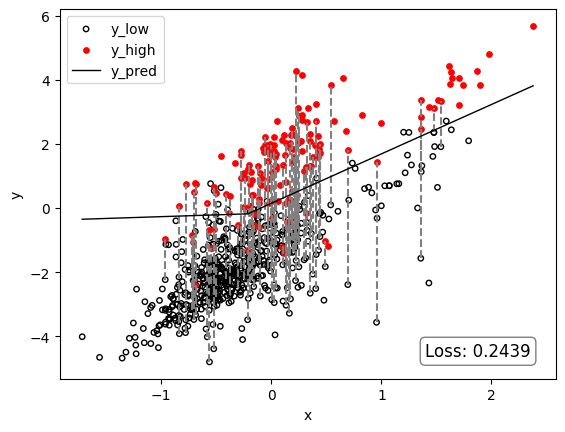

In [5]:
trainer = ModelTrainer(
    dataset='detailed',
    chosen_feature=['log_range_value'],
    test_fold=1
)

trainer.initialize_model()
trainer.train()
trainer.predict()
trainer.plot_results()